In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

In [2]:
test_df = pd.read_excel('/kaggle/input/uit-vsmec/test_nor_811.xlsx')
train_df = pd.read_excel('/kaggle/input/uit-vsmec/train_nor_811.xlsx')
val_df = pd.read_excel('/kaggle/input/uit-vsmec/valid_nor_811.xlsx')

In [3]:
test_df.columns = ['index', 'Emotion', 'Sentence']
train_df.columns = ['index', 'Emotion', 'Sentence']
val_df.columns = ['index', 'Emotion', 'Sentence']

In [4]:
train_df= train_df.drop(columns = ['index'])
test_df = test_df.drop(columns = ['index'])
val_df = val_df.drop(columns = ['index'])

In [5]:
val_df

,Emotion,Sentence
0,Other,"tính tao tao biết , chẳng có chuyện gì có thể ..."
1,Enjoyment,"lại là lào cai , tự hào quê mình quá :))"
2,Sadness,bị từ chối rồi
3,Enjoyment,tam đảo trời đẹp các mem à
4,Other,đọc bình luận của thằng đó không thiếu chữ nào 😂😂
...,...,...
681,Sadness,nhọc lòng :(((
682,Sadness,tao đã rất muốn làm bạn tốt anh em tri kỉ với ...
683,Disgust,cơm tấm ở ngoài cũng như này . 😡
684,Surprise,chất liệu đỉnh quá


In [6]:
val_df

,Emotion,Sentence
0,Other,"tính tao tao biết , chẳng có chuyện gì có thể ..."
1,Enjoyment,"lại là lào cai , tự hào quê mình quá :))"
2,Sadness,bị từ chối rồi
3,Enjoyment,tam đảo trời đẹp các mem à
4,Other,đọc bình luận của thằng đó không thiếu chữ nào 😂😂
...,...,...
681,Sadness,nhọc lòng :(((
682,Sadness,tao đã rất muốn làm bạn tốt anh em tri kỉ với ...
683,Disgust,cơm tấm ở ngoài cũng như này . 😡
684,Surprise,chất liệu đỉnh quá


<Axes: xlabel='Emotion', ylabel='count'>

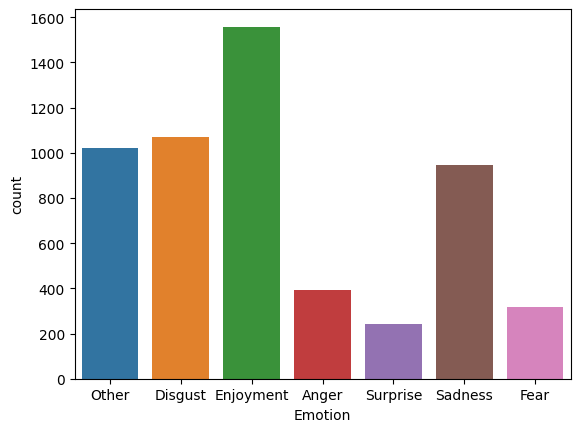

In [7]:
sns.countplot(x='Emotion', data=train_df)


In [8]:
bert = AutoModel.from_pretrained("mr4/phobert-base-vi-sentiment-analysis")
tokenizer = AutoTokenizer.from_pretrained("mr4/phobert-base-vi-sentiment-analysis", use_fast=False)

class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=50):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def labelencoder(self, text):
        if text == 'Enjoyment':
            return 0
        elif text == 'Disgust':
            return 1
        elif text == 'Sadness':
            return 2
        elif text == 'Anger':
            return 3
        elif text == 'Surprise':
            return 4
        elif text == 'Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Emotion'])
        return text, label

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at mr4/phobert-base-vi-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [9]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = bert
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [10]:
import os
n_workers = os.cpu_count()
n_workers

4

In [11]:
train_dataset = SentimentDataset(train_df, tokenizer, max_len=80)
valid_dataset = SentimentDataset(val_df, tokenizer, max_len=80)
test_dataset = SentimentDataset(test_df, tokenizer, max_len=80)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=n_workers)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=n_workers)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 9.444444444444438, 'Token Count')

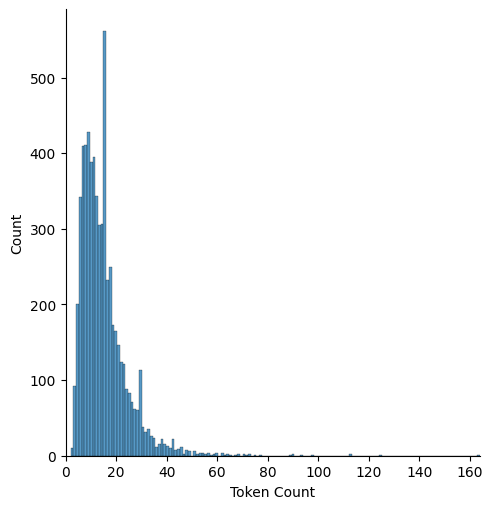

In [12]:
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SentimentClassifier(n_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001)
EPOCHS = 12
lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=200,
                num_training_steps=len(train_loader)*EPOCHS
            )

In [16]:
from sklearn.metrics import f1_score

train_losses = []
train_accuracies = []
train_f1s = []
val_losses = []
val_accuracies = []
val_f1s = []
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    all_preds = []
    all_targets = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
    f1 = f1_score(all_targets, all_preds, average='weighted')
    accuracy = correct.double()/len(train_loader.dataset)
    train_losses.append(np.mean(losses))
    train_accuracies.append(accuracy.cpu().numpy())
    train_f1s.append(f1)
    print(f'Train Accuracy: {accuracy} Loss: {np.mean(losses)}, F1: {f1}')


def eval(valid_loader):
    model.eval()
    losses = []
    all_preds = []
    all_targets = []
    correct = 0

    with torch.no_grad():
        for data in valid_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    f1 = f1_score(all_targets, all_preds, average='weighted')
    accuracy = correct.double()/len(valid_loader.dataset)
    val_losses.append(np.mean(losses))
    val_accuracies.append(accuracy.cpu().numpy())
    val_f1s.append(f1)
    print(f'Val Accuracy: {accuracy} Loss: {np.mean(losses)}, F1={f1}')
    return accuracy

In [17]:
import os
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"

Epoch 1/12
------------------------------
Train Accuracy: 0.31488824801730353 Loss: 1.7896666770631617, F1: 0.20907148519487156
Val Accuracy: 0.4271137026239067 Loss: 1.5491828322410583, F1=0.357173110809386
Epoch 2/12
------------------------------
Train Accuracy: 0.4527757750540735 Loss: 1.5013822506774555, F1: 0.39936878137257503
Val Accuracy: 0.4941690962099125 Loss: 1.3805604378382366, F1=0.4567954625192769
Epoch 3/12
------------------------------
Train Accuracy: 0.5674116798846431 Loss: 1.2326815859837965, F1: 0.5294088261912535
Val Accuracy: 0.5262390670553936 Loss: 1.30585378408432, F1=0.5070888781303176
Epoch 4/12
------------------------------
Train Accuracy: 0.6620403749098774 Loss: 0.9756207208741795, F1: 0.6428883156941865
Val Accuracy: 0.5685131195335277 Loss: 1.2681593696276348, F1=0.5720003567191695
Epoch 5/12
------------------------------
Train Accuracy: 0.740086517664023 Loss: 0.7715185650370338, F1: 0.7355936327706502
Val Accuracy: 0.5830903790087464 Loss: 1.261174

<Axes: >

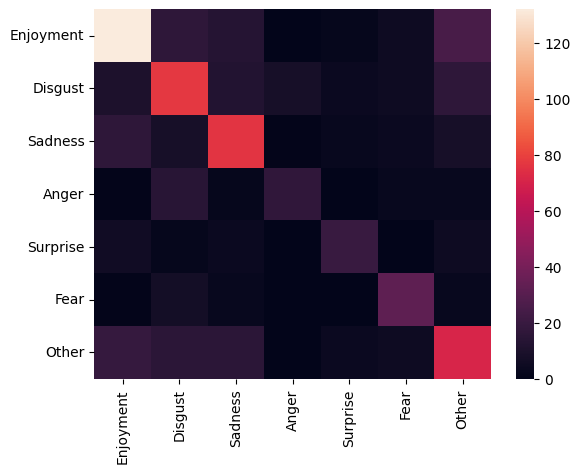

In [18]:
best_acc = 0
best_epoch = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    train(model, criterion, optimizer, train_loader)
    val_acc = eval(valid_loader)

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'phobert_best.pth')
        best_acc = val_acc
        best_epoch = epoch

print('testing')
model.eval()
real_values = []
predicts = []

with torch.no_grad():
    for data in test_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, pred = torch.max(outputs, dim=1)
        real_values.extend(targets.cpu().numpy())
        predicts.extend(pred.cpu().numpy())

test_acc = np.sum(np.array(real_values) == np.array(predicts)) / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc} ')
print(f'best Accuracy: {best_acc} at ep = {best_epoch}')

# Heatmap
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels=class_names, yticklabels=class_names)

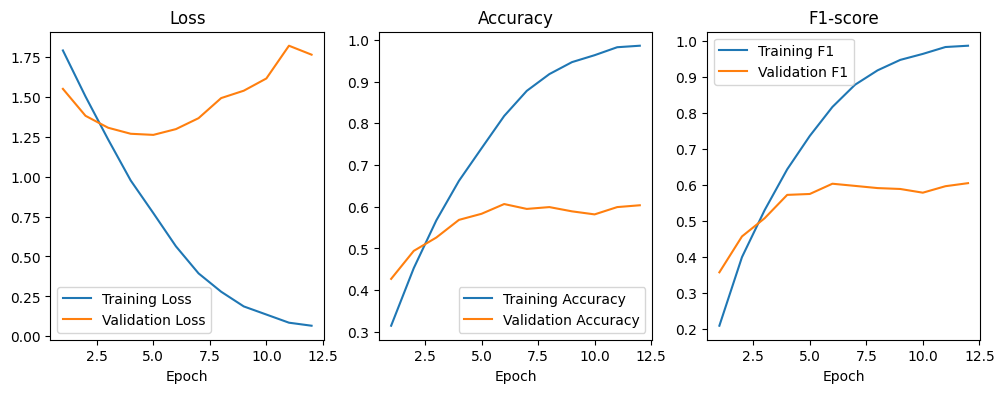

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1s, label='Training F1')
plt.plot(epochs, val_f1s, label='Validation F1')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [21]:
import torch.nn.functional as F

def infer(text, tokenizer, max_len=80):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)
    probs = F.softmax(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')
    for i, prob in enumerate(probs[0]):
        print(f'Sentiment prediction: {class_names[i]} {prob.item()*100:.2f}%')

In [22]:
infer("chúc mọi người 1 ngày vui ", tokenizer)

Text: chúc mọi người 1 ngày vui 
Sentiment: Enjoyment
Sentiment prediction: Enjoyment 98.80%
Sentiment prediction: Disgust 0.09%
Sentiment prediction: Sadness 0.22%
Sentiment prediction: Anger 0.11%
Sentiment prediction: Surprise 0.12%
Sentiment prediction: Fear 0.10%
Sentiment prediction: Other 0.56%


In [ ]:
from huggingface_hub import create_repo
from transformers import AutoConfig

# 1. Lưu tokenizer
tokenizer.save_pretrained("phobert_sentiment")

# 2. Lấy config của model
config = AutoConfig.from_pretrained("vinai/phobert-base")

# 3. Lưu model với config
model.config = config
torch.save(model.state_dict(), "phobert_sentiment/pytorch_model.bin")

# 4. Tạo repo trên Hugging Face (nếu chưa tồn tại)
create_repo(repo_id="lecyanh/phobert_sentiment", exist_ok=True)

# 5. Upload model
api.upload_folder(
    folder_path="SentimentPrediction",
    repo_id="leycanh/phobert_sentiment",
    repo_type="model",
)